# Used Car Regression
**ML Project 1 - Spring 2022**

Collaborators: Ben DeSollar and Matt McDonell

Through research we found that a called GradientBoostingRegressor worked the best after testing a couple different model including
    KNeighborsRegressor, Lasso, Ridge, and DecisionTreeRegressor. We improved our results by modifying our feature selection to include as many features as we 
    could to help predict the best values. Things like weight and Deaft year did not seem to be as important as the draft round and PIE. By modifying our featuiues 
    during testing we were able to find the best model predictions.

### Step 1
Import the required packages and frameworks.

In [5]:
# imports
import numpy as np
from mlwpy import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn import (datasets, neighbors,
                     naive_bayes,
                     model_selection as skms,
                     linear_model, dummy,
                     metrics,
                     pipeline,
                     preprocessing as skpre) 
import csv
from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from category_encoders.ordinal import OrdinalEncoder

### Step 2
Read in the .csv files and create DataFrames

In [6]:
data_train_df = pd.read_csv("cars_reg_train.csv") 
data_test_df = pd.read_csv("cars_reg_test.csv")
data_train_ft = data_train_df.drop('price', axis=1)
data_train_tgt = data_train_df["price"]

### Step 3
Focus down to the features we think will have the largest impact on points scored. 

We tried to stick to more of the physical attributes like age or height over subjective factors, like city or roster status. We believe points are more about the players themselves than the citys/schools they play for.
As well as including whether they are in the NBA or not, active, and the draft selection. Lastly PIE seems to have the greatest impact, even though there are not a lot of them in the data. 

In [7]:
# To see what kind of data we're working with
print(data_train_ft.dtypes)
print(data_train_ft.head(5))

# From looking at the data it looks like Draft and all star apperances should be useful. 
# Feauture used will need to be transformed into numbers in order to use the prediction models and have them be uniform≥ 

Unnamed: 0        int64
url              object
region           object
region_url       object
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object
   Unnamed: 0                                                url  \
0      259073  https://newjersey.craigslist.org/cto/d/bloomin...   
1      445077  https://denver.craigslist.org/cto/d/henderson-...   
2      109862  https://spacecoast.craigslist.org/cto/d/merrit...   
3       17375  https://yuma.craigslist.org/cto/d/yuma-2016-fo...   
4       51906  https://sacramento.craigslist.org/ctd/d/san-ra...   

 

### Step 4
Convert numbers to their correct formats and fill in any missing values. 

Missing values don't help us in our quest for accuracy, but filling them in as zero won't necessarily hurt us either. By filling them in, we can still use other parts of the player's data without having to throw away the entire entry.

In [8]:

# 5 6 8 12 13

features = ['year',\
            'odometer',
            'lat',
            'long',
            'drive',
            'size',
            #'posting_date',
            'fuel',
            'condition',
            'model',
            'paint_color',
            'cylinders',
            'manufacturer',
            'VIN',
            'state',
            'type'
            ]

data_train_ft = data_train_ft[features]
data_train_ft = data_train_ft.fillna(0)

data_test_ft = data_test_df
data_test_df = data_test_df[features]
data_test_df = data_test_df.fillna(0)

'''
TE_encoder = TargetEncoder()
data_train_ft = TE_encoder.fit_transform(data_train_ft, data_train_tgt)
data_test_df = TE_encoder.transform(data_test_df)
'''
'''
LOOE_encoder = LeaveOneOutEncoder()
data_train_ft = LOOE_encoder.fit_transform(data_train_ft, data_train_tgt)
data_test_df = LOOE_encoder.transform(data_test_df)
'''

LE_encoder = OrdinalEncoder(features)
data_train_ft = LE_encoder.fit_transform(data_train_ft)
data_test_df = LE_encoder.transform(data_test_df)
data_train_ft.head()

'''
ftrsel = ftr_sel.SelectKBest(ftr_sel.f_classif, k=5)
ftrsel.fit_transform(data_train_ft, data_train_tgt)

keepers_idx = ftrsel.get_support()
print(keepers_idx)
# use target encoding to encode two categorical features

ftrsel = ftr_sel.SelectFromModel(ensemble.RandomForestClassifier(), 
                                 threshold='mean') # default
'''
ftrsel = ftr_sel.SelectKBest(ftr_sel.f_classif, 
                                  k=7)

#ftrsel = ftr_sel.RFE(ensemble.RandomForestClassifier(),
                    # n_features_to_select=7)
ftrsel.fit_transform(data_train_ft, data_train_tgt)

print(np.array(features)[ftrsel.get_support()])
new_features = np.array(features)[ftrsel.get_support()]
data_train_ft = data_train_ft[new_features]
data_test_df = data_test_df[new_features]

['year' 'long' 'drive' 'fuel' 'condition' 'cylinders' 'VIN']


### Step 5
Create a heat map to visualize trends present in the data.

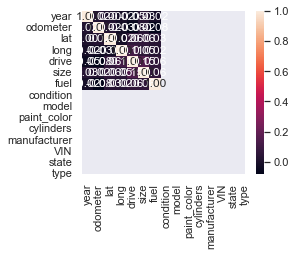

In [9]:
correlation_map = np.corrcoef(data_train_ft.values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=features, xticklabels=features)

plt.show()

### Step 6
Split the data into training and validation sets for use with cross-validation scoring. We split the data randomly to lower the chances of overfitting.

In [10]:
train_plus_validation_ftrs, test_ftrs, train_plus_validation_tgt, test_tgt = train_test_split (data_train_ft, data_train_tgt, test_size = 0.20,
                                   random_state = 42)

### Step 7
This is another portion where accuracy is most directly influenced. We added as many models as possible (within reason) to ensure that we were covering all our bases to get the most accurate predictions.

In [11]:

pipelines = {
    'LR' : LinearRegression(),
    'CART' : DecisionTreeRegressor(max_depth=10),
    'RandomForest' : sklearn.ensemble.RandomForestRegressor(n_estimators=20, max_depth=10)}
for k in range(1,11,2):
    pipelines[f'KNN-{k}'] = KNeighborsRegressor(n_neighbors=k)
for i in range(25,45,5):
    pipelines[f'GBR-{i}'] = GradientBoostingRegressor(random_state=21, n_estimators=i)
values = [0.25, 0.50, 10, 20, 25, 30, 35, 40, 50, 100]
for alpha_value in values:
    pipelines[f'Lasso (C={alpha_value})'] = linear_model.Lasso(alpha=alpha_value)
    pipelines[f'Ridge (C={alpha_value})'] = linear_model.Ridge(alpha=alpha_value)
print(pipelines)




{'LR': LinearRegression(), 'CART': DecisionTreeRegressor(max_depth=10), 'RandomForest': RandomForestRegressor(max_depth=10, n_estimators=20), 'KNN-1': KNeighborsRegressor(n_neighbors=1), 'KNN-3': KNeighborsRegressor(n_neighbors=3), 'KNN-5': KNeighborsRegressor(), 'KNN-7': KNeighborsRegressor(n_neighbors=7), 'KNN-9': KNeighborsRegressor(n_neighbors=9), 'GBR-25': GradientBoostingRegressor(n_estimators=25, random_state=21), 'GBR-30': GradientBoostingRegressor(n_estimators=30, random_state=21), 'GBR-35': GradientBoostingRegressor(n_estimators=35, random_state=21), 'GBR-40': GradientBoostingRegressor(n_estimators=40, random_state=21), 'Lasso (C=0.25)': Lasso(alpha=0.25), 'Ridge (C=0.25)': Ridge(alpha=0.25), 'Lasso (C=0.5)': Lasso(alpha=0.5), 'Ridge (C=0.5)': Ridge(alpha=0.5), 'Lasso (C=10)': Lasso(alpha=10), 'Ridge (C=10)': Ridge(alpha=10), 'Lasso (C=20)': Lasso(alpha=20), 'Ridge (C=20)': Ridge(alpha=20), 'Lasso (C=25)': Lasso(alpha=25), 'Ridge (C=25)': Ridge(alpha=25), 'Lasso (C=30)': Lass

### Step 8
Using different standardizing pipelines, run multiple cross-validation tests on the data splits to find the best performing model.

Further refine the selection of best model by comparing scores.

In [12]:

accuracy_scores = {}
for pipeline_name in pipelines:
    #loo = skms.LeaveOneOut()
    scores = skms.cross_val_score(pipelines[pipeline_name],
                                  train_plus_validation_ftrs,
                                  train_plus_validation_tgt,
                                  #cv=loo,
                                  cv=10,
                                  scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores.mean())
    accuracy_scores[pipeline_name] = scores
    print(f'{pipeline_name}: {scores:.3f}')

best_model_name = min(accuracy_scores,key=accuracy_scores.get)
print(f'\nBest model: {best_model_name} (accuracy = {accuracy_scores[best_model_name]:.3f})')
final_model = pipelines[best_model_name]

## Took my computer 3 min 14 sec to run this

LR: 9028104.077
CART: 15629133.278


### Step 9
Rescale the data and fit the model.

In [ ]:
scaler = StandardScaler().fit(train_plus_validation_ftrs)
rescaled_train_plus_validation_ftrs = scaler.transform(train_plus_validation_ftrs)
car_scores_fit = final_model.fit(rescaled_train_plus_validation_ftrs, 
                                   train_plus_validation_tgt)
rescaled_test_ftrs = scaler.transform(data_test_df)

### Step 10
Scale the data and predict points on the selected model and save it in a temporary .csv for analysis.

In [ ]:

predictions = car_scores_fit.predict(rescaled_test_ftrs)
# score = np.sqrt(metrics.mean_squared_error(predictions, tes))
print(f'Using model: {final_model} and features: {features}')
# print(f'Final score: {score:.3f}')
# predictions = model.predict(rescaled_test_ftrs)

# compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : test_tgt})
# compare.head(10)
# This is just using the test.csv to setup a dataframe of the correct size
# and indicies (the "id" field).
make_submission_df = pd.read_csv("cars_reg_test.csv")
# drop all columns except 'id'
make_submission_df = make_submission_df[['id']]
# make sure the column of ID's that we just read in is the index column
make_submission_df = make_submission_df.set_index('id')

Using model: Lasso(alpha=100) and features: ['year', 'odometer', 'lat', 'long', 'title_status']


### Step 11
Add our predictions to a submission file and save the final .csv

In [ ]:
make_submission_df['price'] = predictions
make_submission_df.to_csv('submission.csv',sep=',', float_format='%.2f')